In [37]:
# original size 258866 # 258841 # 258816
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from data_preprocessing import preprocessing
import json
from send2trash import send2trash

In [38]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)

In [39]:
dl = DataLoader(dataset=dataset, batch_size=64, num_workers=0, sampler=None, shuffle=False)

In [40]:
df_measurements = pd.read_pickle("measurements_2.pickle")

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

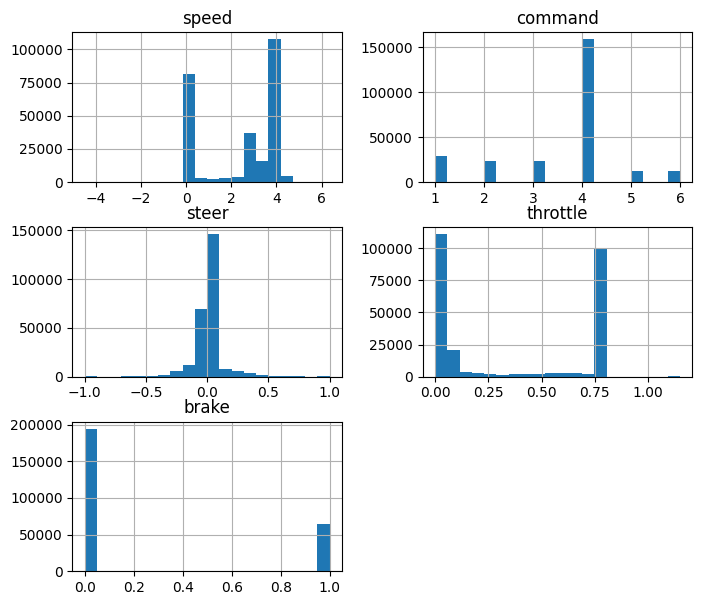

In [41]:
df_measurements.hist(figsize=(8, 7), bins=20)

In [56]:
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

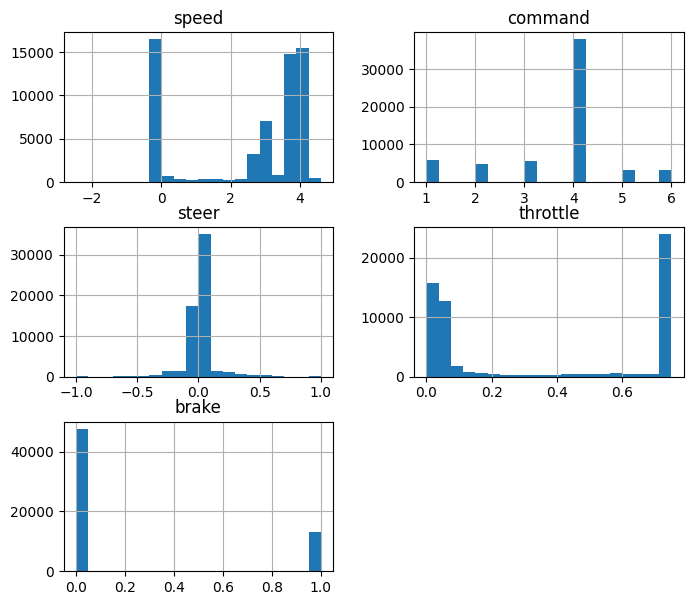

In [58]:
df_measurements_train = df_measurements[df_measurements.index.isin(df_meta_data_train.index)]
df_measurements_train.hist(figsize=(8, 7), bins=20)

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

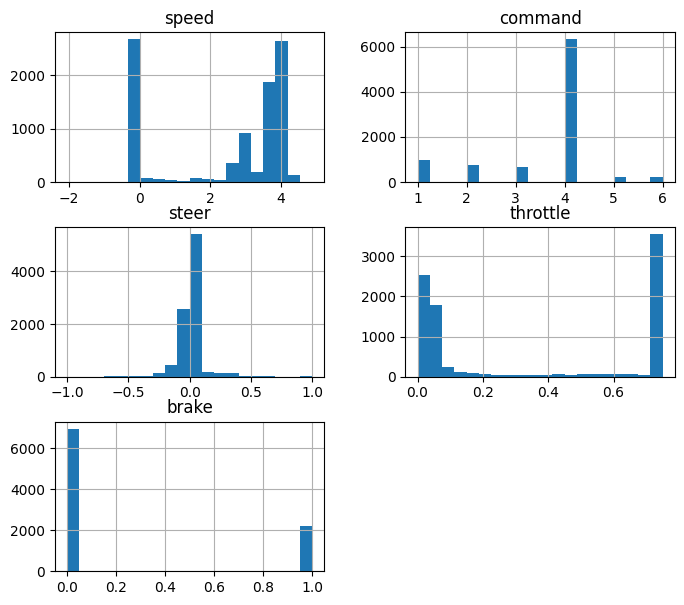

In [59]:
df_measurements_test = df_measurements[df_measurements.index.isin(df_meta_data_test.index)]
df_measurements_test.hist(figsize=(8, 7), bins=20)

In [60]:
df_measurements.describe()

,speed,command,steer,throttle,brake
count,2.588410e+05,258841.000000,258841.000000,258841.000000,258841.000000
mean,2.382354e+00,3.521281,0.000925,0.347408,0.249114
std,1.724855e+00,1.216387,0.127027,0.346909,0.432501
min,-4.490779e+00,1.000000,-1.000000,0.000000,0.000000
25%,5.883324e-08,3.000000,-0.005500,0.000000,0.000000
50%,3.082419e+00,4.000000,0.000000,0.105181,0.000000
75%,3.861652e+00,4.000000,0.002000,0.750000,0.000000
max,6.353220e+00,6.000000,1.000000,1.150000,1.000000


In [44]:
freq_classes = {"steer":{
                            "1": (lambda ser: ser.between(-1.1, -0.4, inclusive="left")),
                            "2": (lambda ser: ser.between(-0.4, -0.1, inclusive="left")),
                            "3": (lambda ser: ser.between(-0.1, 0.1, inclusive="left")),
                            "4": (lambda ser: ser.between(0.1, 0.4, inclusive="left")),
                            "5": (lambda ser: ser.between(0.4, 1.1, inclusive="left")),
                        }
                }               

In [45]:
def steer_classifier(steer):
    if -1 <= steer < -0.4:
        return 1
    elif -0.4 <= steer < -0.1:
        return 2
    elif -0.1 <= steer < 0.1:
        return 3
    elif 0.1 <= steer < 0.4:
        return 4
    elif 0.4 <= steer < 1.1:
        return 5

In [46]:
df_measurements["steer"].apply(steer_classifier)# .plot(kind="pie")

0         3
1         3
2         3
3         3
4         3
         ..
258836    3
258837    3
258838    3
258839    3
258840    3
Name: steer, Length: 258841, dtype: int64

In [47]:
ser_temp = []
for key_class in freq_classes["steer"]:
    ser = freq_classes["steer"][key_class](df_measurements["steer"])
    ser.name = key_class
    ser_temp.append(ser)

In [48]:
df_classes = pd.concat(ser_temp, axis=1)
df_classes_check = df_classes.sum(axis=1)

In [49]:
# df_meta_data.to_pickle("meta_data_entire.pickle")

# Creating classes for continous variables using histograms

In [50]:
hist, bin_edges = np.histogram(df_measurements["steer"], bins=5)
bin_edges[-1] = 1.1

In [51]:
bin_mapping = np.digitize(df_measurements["steer"], bins=bin_edges,)
bin_mapping_count = pd.DataFrame(bin_mapping).value_counts(normalize=True).sort_index()

In [52]:
bin_mapping_weighted = np.zeros(len(bin_mapping))
for idx, bin_map in enumerate(bin_mapping):
    bin_mapping_weighted[idx] = bin_mapping_count.loc[bin_map]

In [53]:
bin_mapping_weighted = 1 / bin_mapping_weighted

In [54]:
# (bin_mapping_weighted / bin_mapping_weighted.sum()).sum() = 1
sample_weights_entire = (bin_mapping_weighted / bin_mapping_weighted.sum())

In [55]:
# (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum()).sum() = 1
sample_weights_first_batch = (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum())